In [29]:
%matplotlib inline

In [30]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # 대화형 모드

# 데이터 불러오기
데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

우리는 개미와 벌을 분류하는 모델을 학습할 것인데 우리에게 주어진 데이터의 양이 너무 적어 처음부터 학습을 하면 성능이 좋지 못하게 나옵니다.

따라서 전이학습을 통하여 일반화를 할 것입니다.


In [31]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화

# trainsforms.Compose : 이미지를 처리할 것인데 이 때 compose를 사용하여 함께 연결이 가능하다.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = 'data/hymenoptera_data'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
"""
image_datasets = 
{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}
"""

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes  # train폴더 내에 있는 폴더의 종류를 classes로 삼음

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

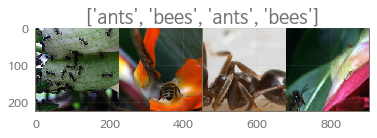

In [4]:
import torch
import torch.utils.data

def imshow(inp, title=None):

    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, nn.Linear(num_ftrs, len (class_names))로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/20143086/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.5MB/s]


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5921 Acc: 0.7049
val Loss: 0.4703 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.4509 Acc: 0.8074
val Loss: 0.2016 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3766 Acc: 0.8361
val Loss: 0.4152 Acc: 0.8301

Epoch 3/24
----------
train Loss: 0.4633 Acc: 0.8238
val Loss: 0.3344 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.3808 Acc: 0.8402
val Loss: 0.6027 Acc: 0.8170

Epoch 5/24
----------
train Loss: 0.4411 Acc: 0.8361
val Loss: 0.3669 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5689 Acc: 0.7910
val Loss: 0.3191 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3839 Acc: 0.8074
val Loss: 0.3292 Acc: 0.8889

Epoch 8/24
----------
train Loss: 0.3340 Acc: 0.8484
val Loss: 0.2344 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3765 Acc: 0.8279
val Loss: 0.3174 Acc: 0.8954

Epoch 10/24
----------
train Loss: 0.2898 Acc: 0.8607
val Loss: 0.2305 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.3266 Acc: 0.8402
val Loss: 0.2528 Acc: 0.8954

Ep

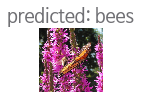

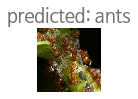

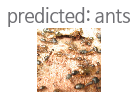

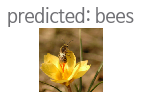

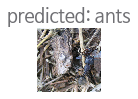

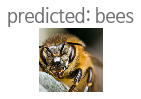

In [9]:
visualize_model(model_ft)


In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습율 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6395 Acc: 0.6680
val Loss: 0.3081 Acc: 0.8627

Epoch 1/24
----------
train Loss: 0.5968 Acc: 0.7336
val Loss: 0.2023 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5959 Acc: 0.7582
val Loss: 0.2363 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.4252 Acc: 0.8033
val Loss: 0.1780 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.5052 Acc: 0.7869
val Loss: 0.2083 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.4716 Acc: 0.8320
val Loss: 0.2039 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4267 Acc: 0.8402
val Loss: 0.2079 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3100 Acc: 0.8648
val Loss: 0.1818 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3791 Acc: 0.8566
val Loss: 0.1962 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3179 Acc: 0.8607
val Loss: 0.1863 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3417 Acc: 0.8361
val Loss: 0.1693 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3276 Acc: 0.8525
val Loss: 0.1759 Acc: 0.9346

Ep

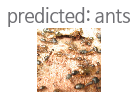

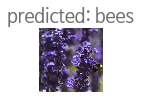

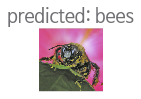

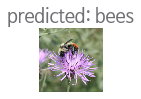

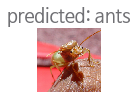

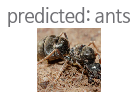

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [165]:
def calc_distance(subin, brother):
    if subin > brother:
        return subin-brother
    if subin == 0:
        answer = 0
        while(brother >0):
            if(brother %2 == 1):
                answer+=1
            brother = int(brother / 2)
        return answer
    brother_temp = brother
    
    answer = 0
    count = 0
    num = 1

    while(1):
       # print("!")
        if(abs(int(brother_temp/2) - subin) > abs(brother_temp - subin)):
            answer = abs(brother_temp - subin)
#             if(brother_temp < subin):
#                 brother_temp = int(brother_temp/2)
#                 count+=1
            break
        count +=1
        brother_temp = int(brother_temp/2)
    
    #print(answer)
    #print(count)
    brother -= brother_temp *(2 **(count))
    #print("brother : ", brother)

    #print("brother temp : ", brother_temp)
    untils = 2**(count)
    #print(untils)
    while(brother > 0):
    #print("@")
        if(brother %2 == 1):
            answer+=1
        brother = int(brother/2)
    return answer





subin, brother = map(int, input().split())


mins = 1000000
for i in range((brother- subin)*2):
    num2 = i - int((brother- subin))
    
    answer = calc_distance(subin, brother - num2)
    if (abs(num2) + answer < mins):
        mins = abs(num2) + answer

print(mins)


0 12156
10


In [ ]:
def calc_distance(subin, brother):
    if subin > brother:
        return subin-brother
    
    brother_temp = brother
    
    answer = 0
    count = 0
    num = 1

    
    
    while(1):
        if(abs(int(brother_temp/2) - subin) > abs(brother_temp - subin)):
            answer = abs(brother_temp - subin)
#             if(brother_temp < subin):
#                 brother_temp = int(brother_temp/2)
#                 count+=1
            break
        count +=1
        brother_temp = int(brother_temp/2)
    
#    print(answer)
#    print(count)
    brother -= brother_temp *(2 **(count))
#    print("brother : ", brother)
#    print("brother temp : ", brother_temp)
    untils = 2**(count)
    #print(untils)
    while(brother > 0):
        if(brother %2 == 1):
            answer+=1
        brother = int(brother/2)
    return answer




from random import *
while(1):
    #subin, brother = map(int, input().split())
    subin = randint(1, 100000)
    brother = randint(1, 100000)
    
    if subin > brother:
        T = subin
        subin = brother
        brother = T
    
    
    mins = 1000000
    for i in range(3):
        num2 = i - 1

        answer = calc_distance(subin, brother - num2)
        if (abs(num2) + answer < mins):
            mins = abs(num2) + answer

    print(subin, " , " , brother, " : ",mins)

    

In [226]:
subin, brother = map(int, input().split())

if subin == 0:
    answerArray = [0,1]
    subin = 1
else:
    answerArray = [subin - i for i in range(subin + 1)]

#print(answerArray)


for i in range(brother - subin + 1):
    answer = answerArray[subin+i] + 1
    if (subin + i + 1) % 2 == 0:
        answer2 = answerArray[int((subin+i+1)/2)]
        if answer2 < answer:
            answer = answer2
            T = subin + i
#             answerArray[T] = answer + 1
#            T-=1
            answerArray.append(answer)
            while(1):
                if(answerArray[T]-answerArray[T + 1]  > 1):
                    answerArray[T] = answerArray[T+1] + 1
                    T-=1
                else:
                    break
            continue
            
    answerArray.append(answer)
for i in range(subin, brother + 1):
    if(answerArray[i] - answerArray[i + 1] >1):
        answerArray
#print(answerArray)
print(answerArray[brother])
   

0 65
[0, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2, 3, 2, 2, 1, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 1, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 4, 3, 4, 3, 3, 2, 3, 3, 4, 3, 4, 3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 1, 2, 2]
2


In [192]:
for i in range(1, 10, 2):
    print(i)

1
3
5
7
9
